In [6]:
from utils import *
from matplotlib.ticker import MultipleLocator
import vice
from vice.yields.presets import JW20
import dill

# Plot settings
plt.rcParams.update({
    'xtick.direction': 'in',
    'xtick.top': True,
    'ytick.direction': 'in',
    'ytick.right': True,
    'figure.dpi': 140,
    'figure.figsize': (4, 4),
    'font.family': 'STIXgeneral',
    'mathtext.fontset': 'cm',
})

In [2]:
# Import data
# data_dir = '/mnt/c/Users/dubay.11/OneDrive - The Ohio State University/Documents/Docs/First Year Project/Data'
data_dir = '~/Documents/Data'
data = pd.read_csv(Path(data_dir) / 'dr17_cut_data.csv')
data

,APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,...,APOKASC2_AGE,APOKASC2_AGE_PERR,APOKASC2_AGE_MERR,APOKASC2_AV,APOKASC2_AV_ERR,APOKASC2_NOTE,APOK2_MASS,APOK2_MASS_ERR,APOK2_RADIUS,APOK2_RADIUS_ERR
0,2M00000002+7417074,apo25m,120+12,none,0.000103,74.285408,119.401807,11.767414,8.597,0.039,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
1,2M00000032+5737103,apo25m,N7789,none,0.001335,57.619530,116.065371,-4.564768,10.905,0.023,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
2,2M00000035-7323394,lco25m,SMC12,none,0.001467,-73.394287,307.939441,-43.230305,15.008,0.045,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
3,2M00000068+5710233,apo25m,N7789,none,0.002850,57.173164,115.977154,-5.002392,10.664,0.023,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
4,2M00000133+5721163,apo25m,NGC7789_btx,none,0.005558,57.354549,116.014776,-4.824917,13.261,0.029,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408656,2M23595867-7339039,lco25m,SMC12,none,359.994493,-73.651093,307.846602,-42.982597,15.671,0.069,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
408657,2M23595886+5726058,apo25m,116-04,none,359.995265,57.434956,116.025359,-4.745011,11.466,0.024,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
408658,2M23595921+5609479,apo25m,NGC7789_MGA,none,359.996744,56.163330,115.771964,-5.991363,11.985,0.023,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
408659,2M23595949-7342592,lco25m,SMC12,none,359.997887,-73.716454,307.821174,-42.919934,15.924,0.094,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN


In [3]:
# Fiducial model: default settings, power-law DTD
simtime = np.linspace(0, 12.5, 1251)
mw = vice.milkyway(name='milkyway/fiducial', N=2e5, zone_width=1.0)
mw.run(simtime)

Output directory already exists. Overwriting will delete all of its contents, leaving only the results of the current simulation.
Output directory: milkyway/fiducial.vice
Overwrite? (y | n)  n


In [42]:
# Fiducial model with wide gaussian DTD
def gauss(t, sigma=1, center=1):
    return np.exp(-(t-center)**2/(2*sigma**2))

mw = vice.milkyway(name='milkyway/wide_gauss', N=2e5, zone_width=1.0)
mw.RIa = lambda t: gauss(t, sigma=2, center=3)
mw.run(simtime)

/home/dubay.11/.local/lib/python3.8/site-packages/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: stars
  warnings.warn("""\
/home/dubay.11/.local/lib/python3.8/site-packages/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: func
  warnings.warn("""\


In [21]:
def multi_zone_plot(vice_name, x, y, data_source='astroNN', zones=[4, 8, 12], xlim=None, ylim=None, 
                    lookback_offset=-2.5, nrows=1, title='', width=10):
    """
    Plot VICE simulation against data for multiple radial zones.
    
    Parameters
    ----------
    vice_name : str
        Name of multizone VICE output.
    x : str
        Parameter to plot on x-axis. Must be 'age' or '[fe/h]'.
    y : str
        Parameter to plot on y-axis. Must be '[fe/h]' or '[o/fe]'.
    data_source : str, optional [default : 'astroNN']
        Source for abundance data (age will always be from astroNN). Must be 'astroNN' or 'ASPCAP'.
    zones : array-like, optional [default : [4, 8, 12]]
        List of radial zones to plot.
    xlim : tuple, optional [default : None]
        Shared x-axis bounds for all panels. If None, default values will be chosen according
        to the x parameter.
    ylim : tuple, optional [default : None]
        Shared y-axis bounds for all panels. If None, default values will be chosen according
        to the y parameter.
    lookback_offset : float, optional [default : -2.5]
        Offset for VICE lookback times in Gyr. Adjust so that simulation and data timescales align.
    nrows : int, optional [default : 1]
        Number of rows of axes.
    title : str, optional [default : '']
        Figure title.
    width : float, optional [default : 10]
        Width of figure in inches.
    
    """
    # Figure dimensions
    n = len(zones)
    ncols = int(np.ceil(n/nrows))
    height = 1.25 * (nrows / ncols) * width
    fig, axs = plt.subplots(nrows, ncols, figsize=(width, height), 
                            sharex=True, sharey=True, tight_layout=True)
    # Set data sources and settings for x-axis
    if x == 'age':
        xdatacol = 'ASTRONN_AGE'
        xvicecol = 'lookback'
        if xlim is None:
            xlim = (-1, 13)
        xlabel = 'astroNN age [Gyr]'
        x_major_locator = 5
        x_minor_locator = 1
    elif x == 'met':
        if data_source == 'astroNN':
            xdatacol = 'ASTRONN_FE_H'
            xlabel = 'astroNN [Fe/H]'
        elif data_source == 'ASPCAP':
            xdatacol = 'M_H'
            xlabel = 'ASPCAP [M/H]'
        xvicecol = '[fe/h]'
        if xlim is None:
            xlim = (-2.1, 0.6)
        x_major_locator = 0.5
        x_minor_locator = 0.1
    # Set data source and settings for y-axis
    if y == 'met':
        if data_source == 'astroNN':
            ydatacol = 'ASTRONN_FE_H'
            ylabel = 'astroNN [Fe/H]'
        elif data_source == 'ASPCAP':
            ydatacol = 'M_H'
            ylabel = 'ASPCAP [M/H]'
        yvicecol = '[fe/h]'
        if ylim is None:
            ylim = (-2.1, 0.6)
        y_major_locator = 0.5
        y_minor_locator = 0.1
    elif y == 'alpha':
        if data_source == 'astroNN':
            ydatacol = 'ASTRONN_O_FE'
            ylabel = 'astroNN [O/Fe]'
        elif data_source == 'ASPCAP':
            ydatacol = 'ALPHA_FE'
            ylabel = r'ASPCAP [$\alpha$/Fe]'
        yvicecol = '[o/fe]'
        if ylim is None:
            ylim = (-0.2, 0.5)
        y_major_locator = 0.2
        y_minor_locator = 0.05
    # Import VICE output
    out = vice.output('milkyway/' + vice_name)
    # Horizontal offset for VICE results
    vice_end = int(lookback_offset * 100)
    
    # Plot data in each zone
    for i, z in enumerate(zones):
        # Select axis
        row = int(i/ncols)
        col = i % ncols
        if nrows > 1:
            ax = axs[row, col]
        else:
            ax = axs[col]
        # Plot data within radial zone
        data_zone = data[(data['ASTRONN_GALR'] >= z) & (data['ASTRONN_GALR'] < z+1)]
        scatter_hist(ax, data_zone[xdatacol], data_zone[ydatacol], xlim=xlim, ylim=ylim)
        # Plot VICE output within zone
        vice_hist = out.zones['zone%s' % z].history
        xvicearr = np.array(vice_hist[xvicecol][:vice_end])
        if xvicecol == 'lookback':
            xvicearr += lookback_offset
        ax.plot(xvicearr, vice_hist[yvicecol][:vice_end], color='r')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        # Set axis tick locators
        ax.xaxis.set_major_locator(MultipleLocator(x_major_locator))
        ax.xaxis.set_minor_locator(MultipleLocator(x_minor_locator))
        ax.yaxis.set_major_locator(MultipleLocator(y_major_locator))
        ax.yaxis.set_minor_locator(MultipleLocator(y_minor_locator))
        # Axis labels on outside of grid only
        if row == nrows - 1:
            ax.set_xlabel(xlabel)
        if col == 0:
            ax.set_ylabel(ylabel)
        ax.set_title(r'%s$\leq R <$%s kpc' % (z, z+1))

    fig.suptitle(title)
    plt.show()

In [38]:
def single_zone_plot(vice_name, zone, tlim=(-1, 13), felim=(-2.1, 0.6), olim=(-0.2, 0.5), data_source='astroNN', lookback_offset=-2.5, title=''):
    """
    Plot [Fe/H] vs age, [O/Fe] vs age, and [O/Fe] vs [Fe/H] for a single radial zone.
    
    Parameters
    ----------
    vice_name : str
        Name of VICE output directory.
    zone : int
        Index of radial zone.
    tlim : tuple, optional [default: (-1, 13)]
        Plot bounds for age or lookback time in Gyr.
    felim : tuple, optional [default: (-2.1, 0.6)]
        Plot bounds for [Fe/H].
    olim : tuple, optional [default: (-0.2, 0.5)]
        Plot bounds for [O/Fe].
    data_source : str, optional [default : 'astroNN']
        Source for abundance data (age will always be from astroNN). Must be 'astroNN' or 'ASPCAP'.
    lookback_offset : float, optional [default : -2.5]
        Offset for VICE lookback times in Gyr. Adjust so that simulation and data timescales align.
    title : str, optional [default : '']
        Figure title.
    
    """
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    
    # Data column names depending on data source
    if data_source == 'astroNN':
        fe_data_col = 'ASTRONN_FE_H'
        fe_ax_label = 'astroNN [Fe/H]'
        o_data_col = 'ASTRONN_O_FE'
        o_ax_label = 'astroNN [O/Fe]'
    elif data_source == 'ASPCAP':
        fe_data_col = 'M_H'
        fe_ax_label = 'ASPCAP [M/H]'
        o_data_col = 'ALPHA_M'
        o_ax_label = r'ASPCAP [$\alpha$/M]'
        
    # Limit data within radial zone
    data_zone = data[(data['ASTRONN_GALR'] >= zone) & (data['ASTRONN_GALR'] < zone+1)]
    out = vice.output('milkyway/' + vice_name)
    vice_hist = out.zones['zone%s' % zone].history
    # Horizontal offset for VICE results
    vice_end = int(lookback_offset * 100)
    
    # First panel: metallicity vs time
    ax = axs[0]
    scatter_hist(ax, data_zone['ASTRONN_AGE'], data_zone[fe_data_col], xlim=tlim, ylim=felim)
    ax.plot(np.array(vice_hist['lookback'][:vice_end]) + lookback_offset, 
            vice_hist['[fe/h]'][:vice_end], color='r')
    ax.set_xlim(tlim)
    ax.set_ylim(felim)
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax.set_xlabel('astroNN age [Gyr]')
    ax.set_ylabel(fe_ax_label)

    # Second panel: alpha vs time
    ax = axs[1]
    scatter_hist(ax, data_zone['ASTRONN_AGE'], data_zone[o_data_col], xlim=tlim, ylim=olim)
    ax.plot(np.array(vice_hist['lookback'][:vice_end]) + lookback_offset, 
            vice_hist['[o/fe]'][:vice_end], color='r')
    ax.set_xlim(tlim)
    ax.set_ylim(olim)
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    ax.set_xlabel('astroNN age [Gyr]')
    ax.set_ylabel(o_ax_label)

    # Third panel: alpha vs fe
    ax = axs[2]
    scatter_hist(ax, data_zone[fe_data_col], data_zone[o_data_col], xlim=felim, ylim=olim)
    ax.plot(np.array(vice_hist['[fe/h]'][:vice_end]), vice_hist['[o/fe]'][:vice_end], color='r')
    ax.set_xlim(felim)
    ax.set_ylim(olim)
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    ax.set_xlabel(fe_ax_label)
    ax.set_ylabel(o_ax_label)
    
    fig.suptitle(title)
    plt.show()

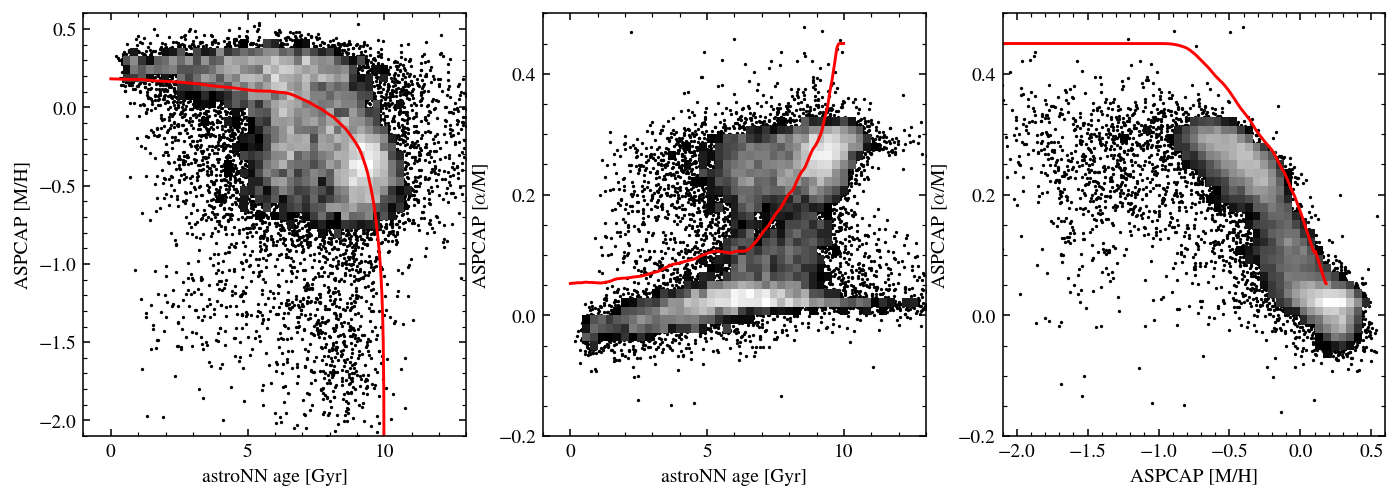

In [41]:
single_zone_plot('fiducial', 4, data_source='ASPCAP')

[]

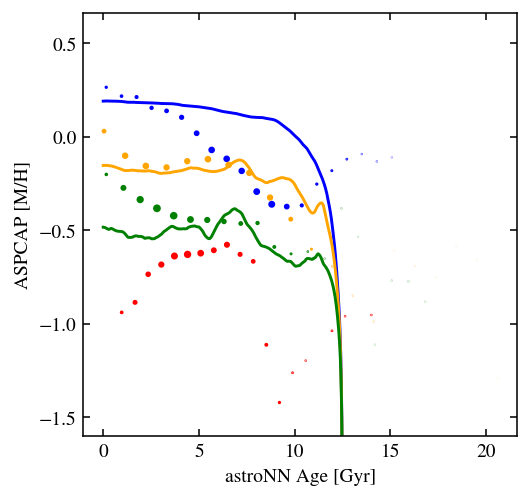

In [32]:
mw_out = vice.multioutput('milkyway/fiducial')

fig, ax = plt.subplots()

colors = ['b', 'orange', 'g', 'r', 'k']
for i, z in enumerate([4, 8, 12, 16]):
    data_zone = data[(data['ASTRONN_GALR'] >= z) & (data['ASTRONN_GALR'] < z+1)][['ASTRONN_AGE', 'M_H']]
    # Bin by age
    ages, age_bins = pd.cut(data_zone['ASTRONN_AGE'], 20, retbins=True)
    # Median [M/H] for each age bin
    median = data_zone['M_H'].groupby(ages).median()
    frac = data_zone['M_H'].groupby(ages).count() / data_zone.shape[0]
    # Plot median [M/H]
    ax.scatter(age_bins[:-1], median, marker='o', s=frac*50, color=colors[i])
    
    # Import VICE zone
    vice_zone = mw.zones[z]
    vice_hist = mw_out.zones[vice_zone.name].history
    ax.plot(np.array(vice_hist['lookback']), vice_hist['[fe/h]'], color=colors[i])

ax.set_ylim((-1.6, None))
ax.set_xlabel('astroNN Age [Gyr]')
ax.set_ylabel('ASPCAP [M/H]')
plt.plot()

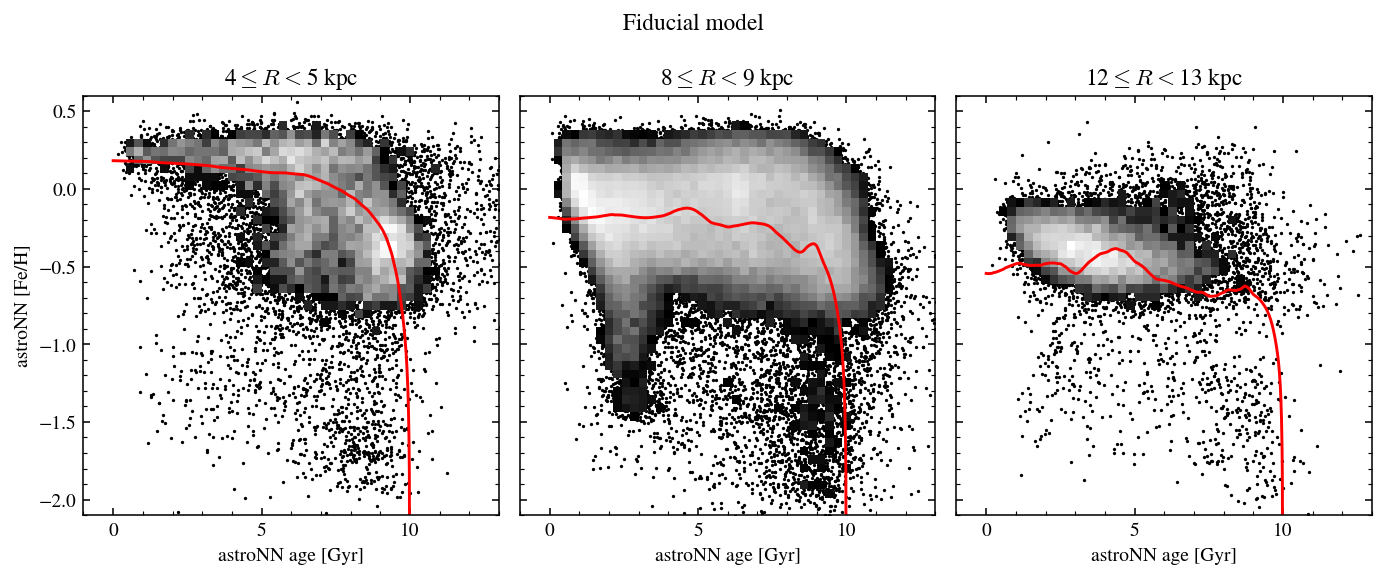

In [19]:
multi_zone_plot('fiducial', 'age', 'met', title='Fiducial model')

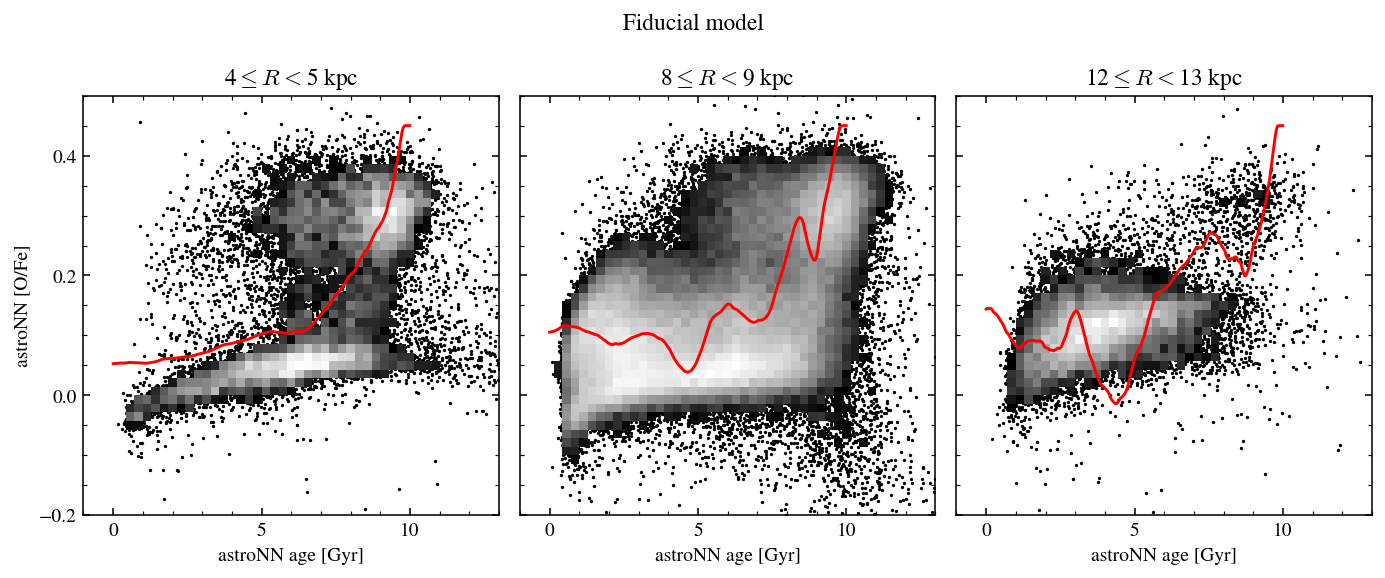

In [22]:
multi_zone_plot('fiducial', 'age', 'alpha', title='Fiducial model')

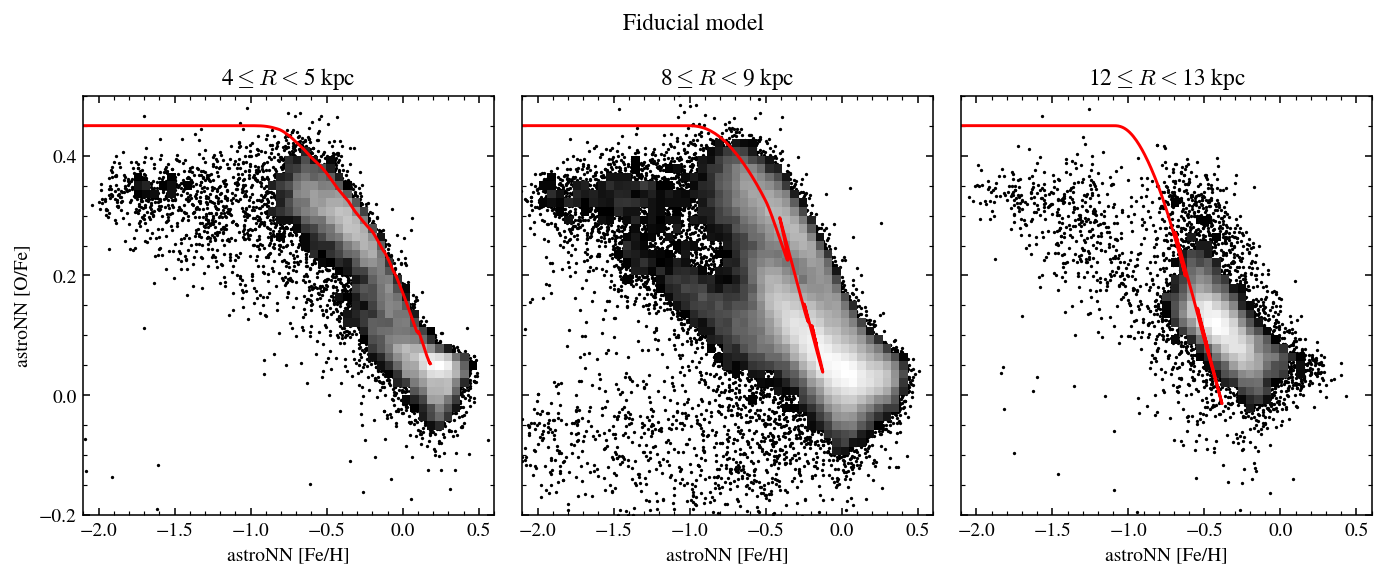

In [23]:
multi_zone_plot('fiducial', 'met', 'alpha', title='Fiducial model')

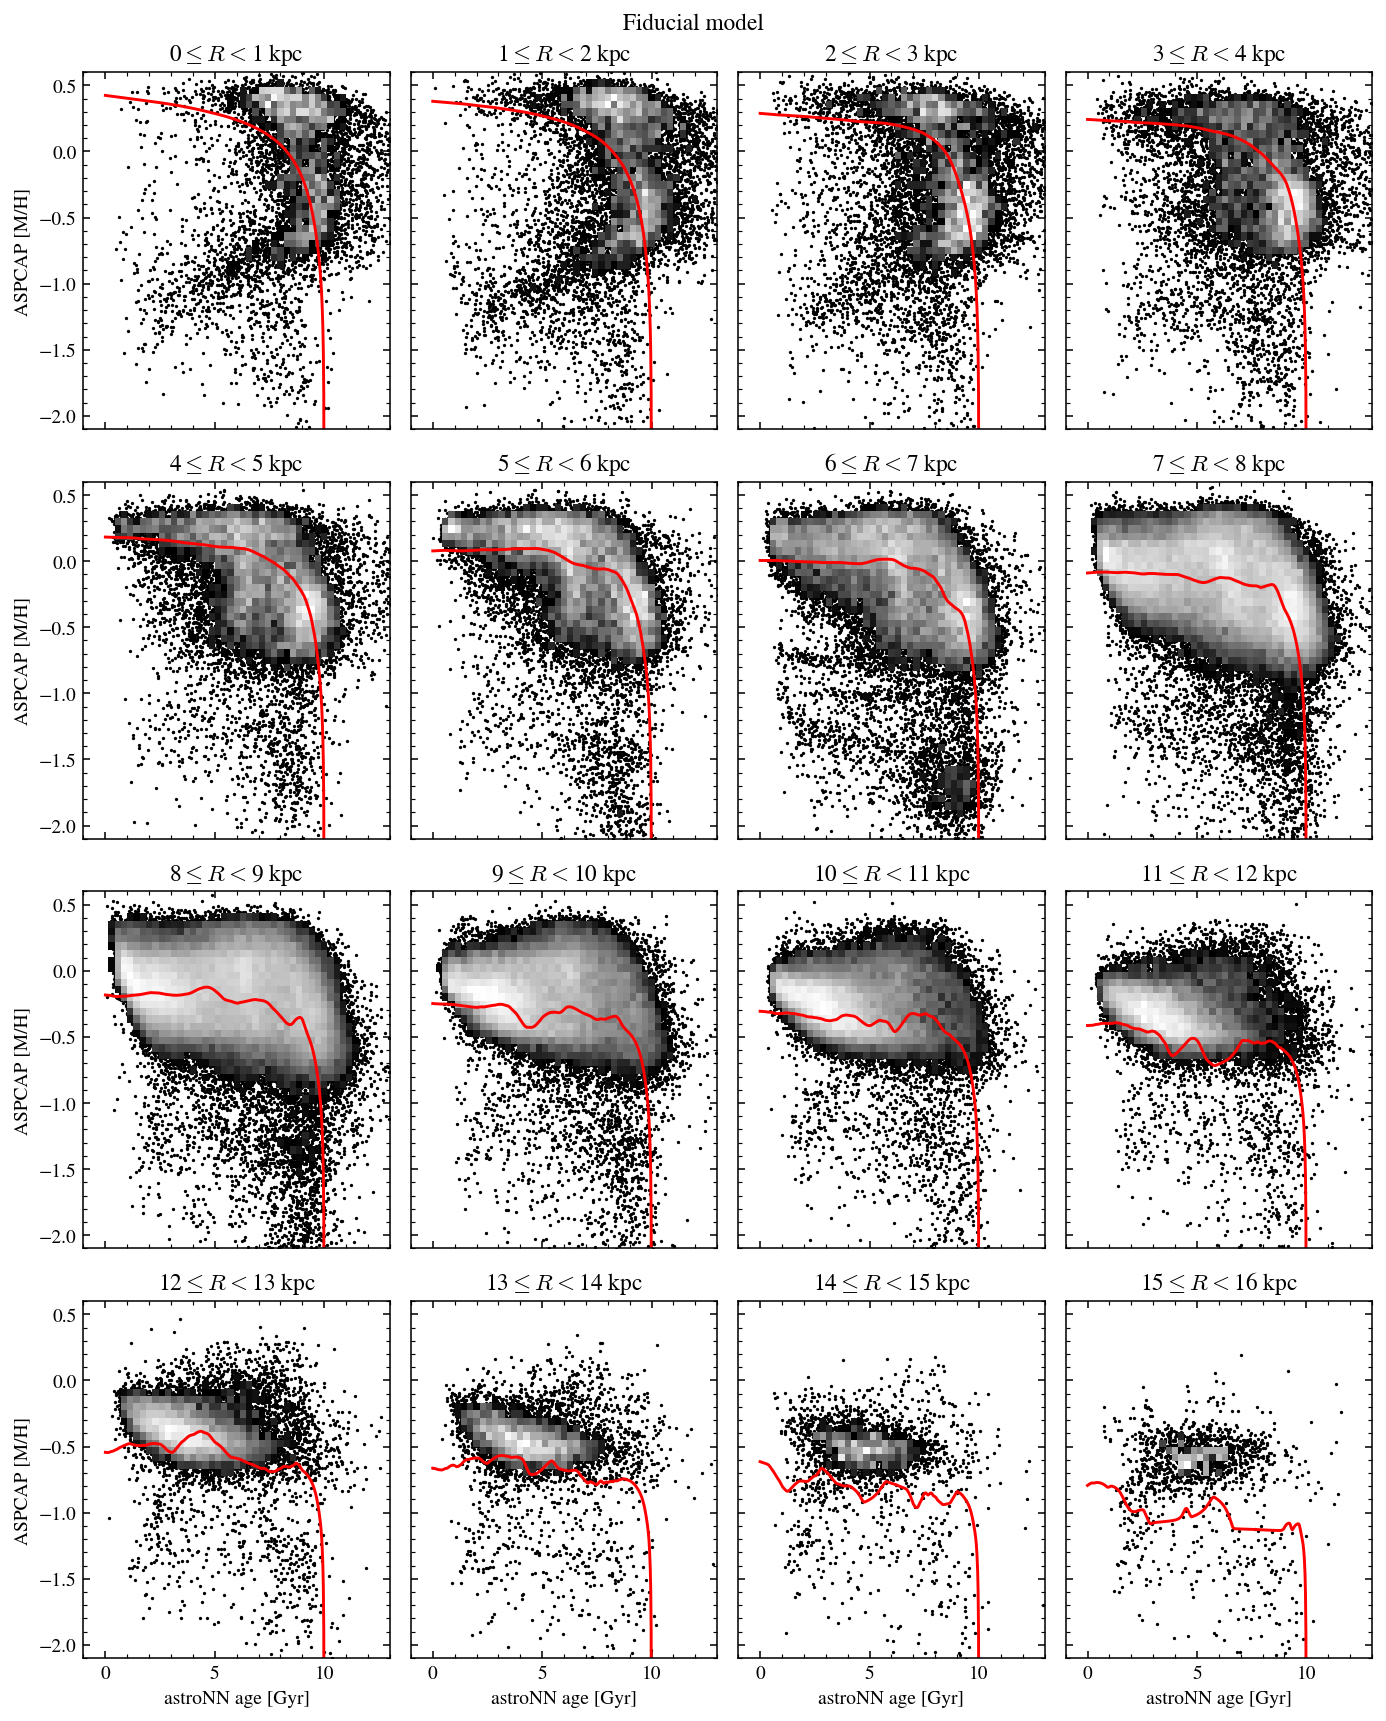

In [17]:
multi_zone_plot('fiducial', 'age', 'met', zones=list(range(16)), nrows=4, title='Fiducial model', data_source='ASPCAP')

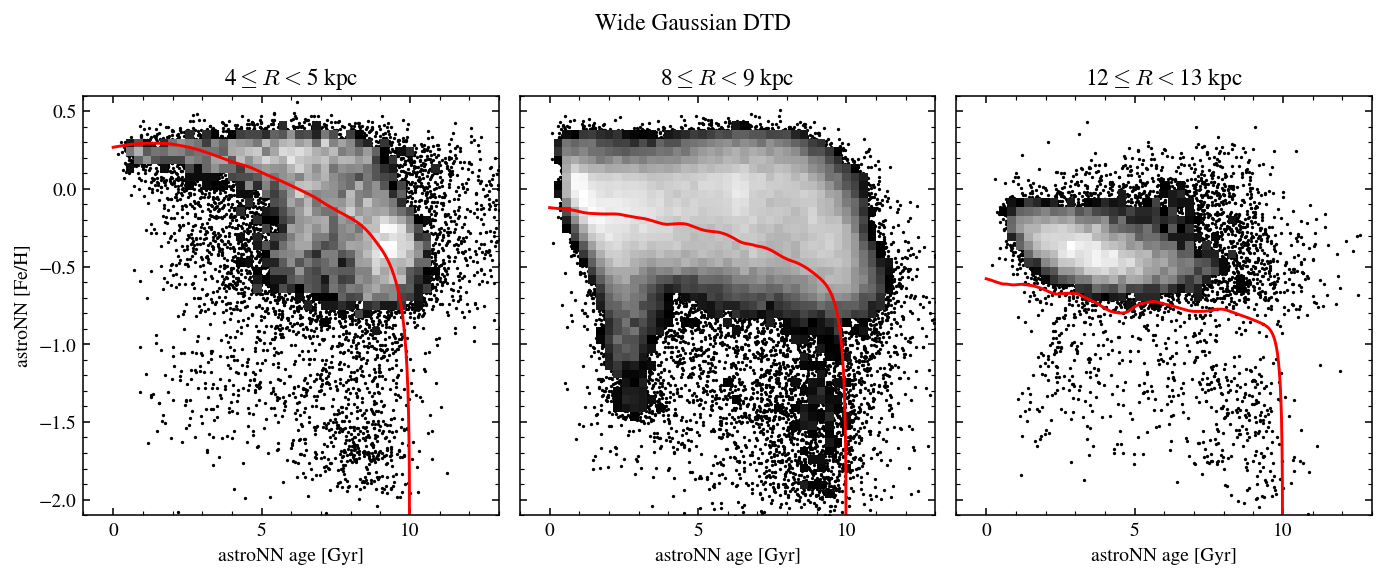

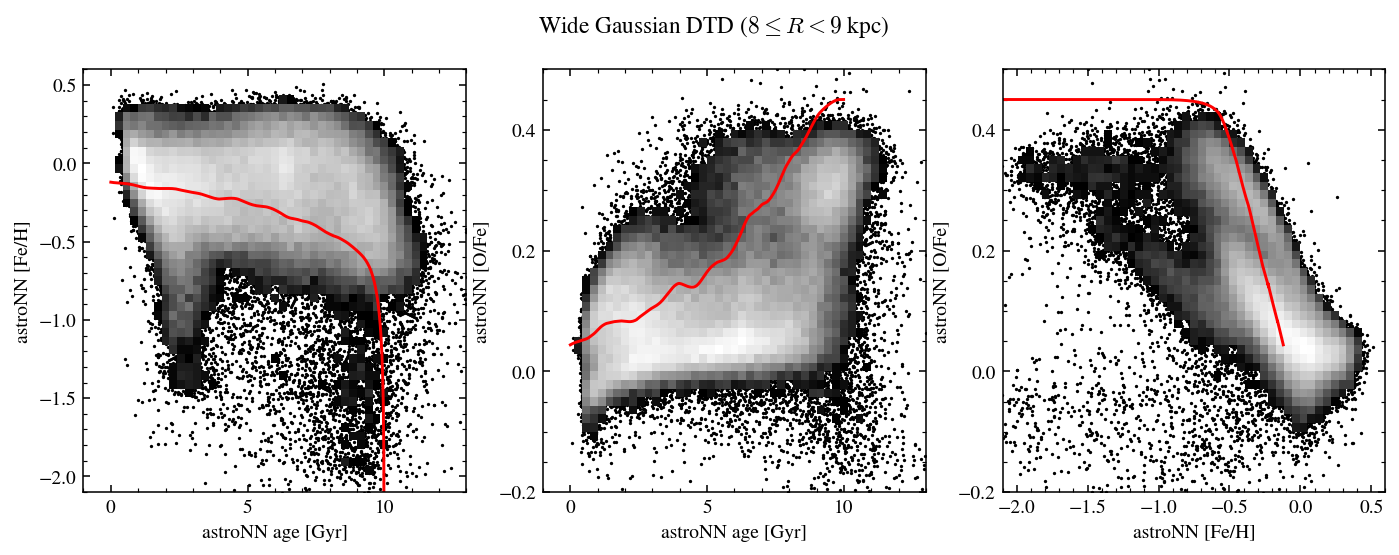

In [44]:
multi_zone_plot('wide_gauss', 'age', 'met', title='Wide Gaussian DTD')
single_zone_plot('wide_gauss', 8, title=r'Wide Gaussian DTD ($8\leq R<9$ kpc)')

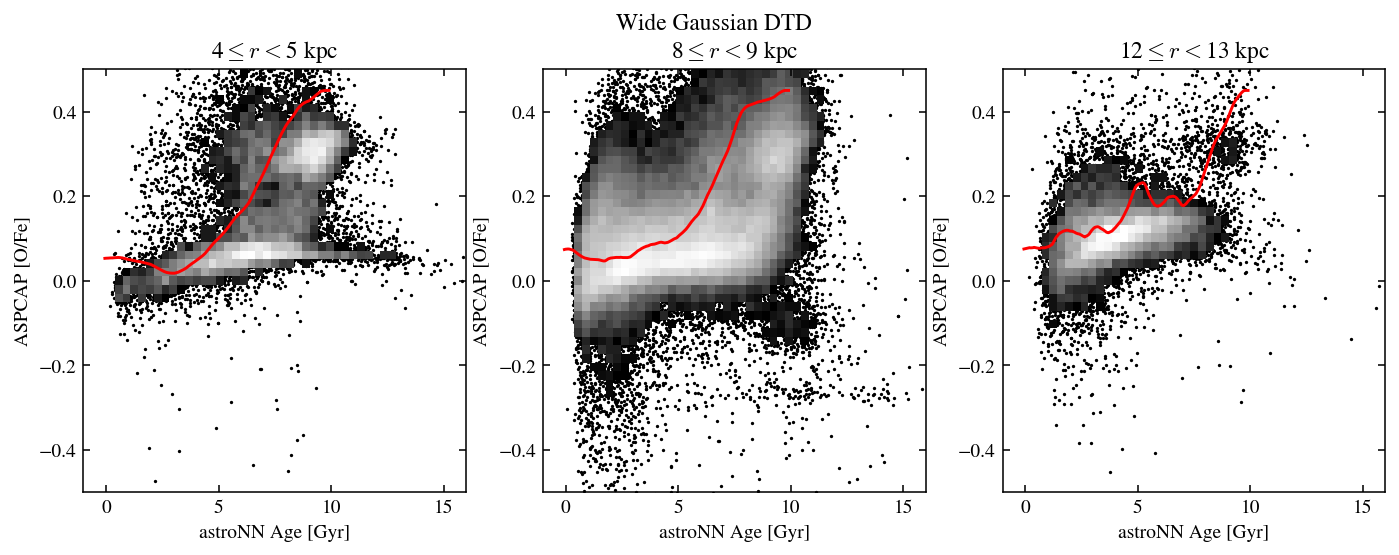

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

mw_out = vice.output('mw_wide')
for i, z in enumerate([4, 8, 12]):
    ax = axs[i]
    xlim = (-1, 16)
    ylim = (-0.5, 0.5)
    data_zone = data[(data['ASTRONN_GALR'] >= z) & (data['ASTRONN_GALR'] < z+1)]
    scatter_hist(ax, data_zone['ASTRONN_AGE'], data_zone['O_FE'], xlim=xlim, ylim=ylim)
    vice_zone = mw.zones[z]
    vice_hist = mw_out.zones[vice_zone.name].history
    ax.plot(np.array(vice_hist['lookback'][:201]) - 2.5, vice_hist['[o/fe]'][:201], color='r')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('astroNN Age [Gyr]')
    ax.set_ylabel('ASPCAP [O/Fe]')
    ax.set_title(r'%s$\leq r <$%s kpc' % (z, z+1))
fig.suptitle('Wide Gaussian DTD')
plt.show()

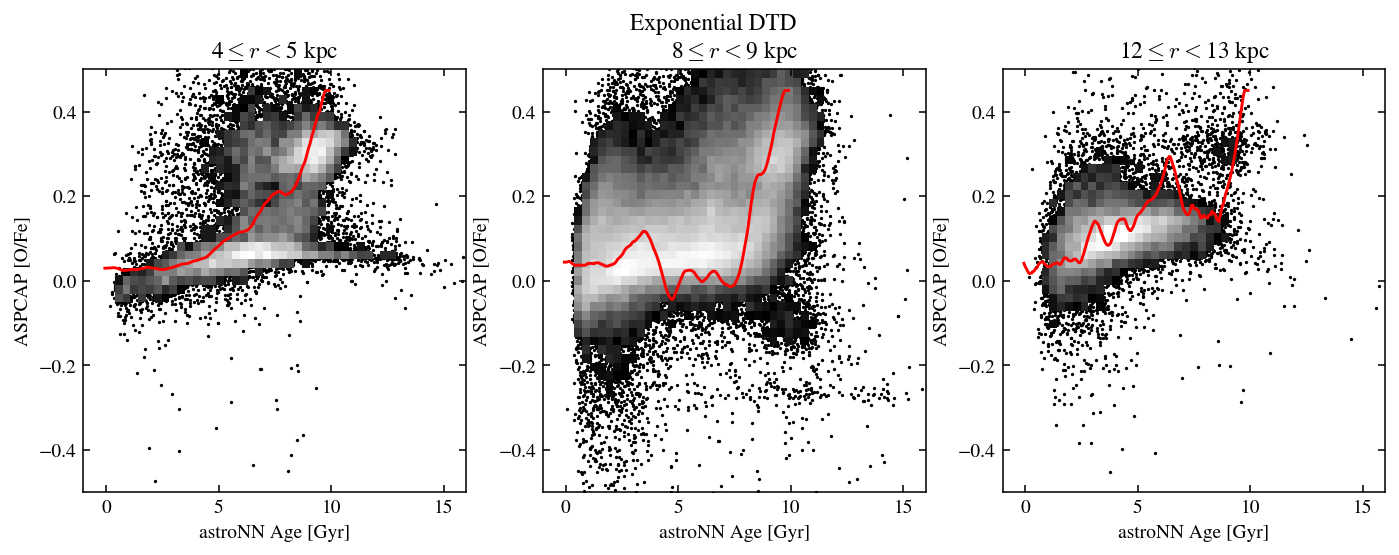

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

mw_out = vice.output('mw_exp')
for i, z in enumerate([4, 8, 12]):
    ax = axs[i]
    xlim = (-1, 16)
    ylim = (-0.5, 0.5)
    data_zone = data[(data['ASTRONN_GALR'] >= z) & (data['ASTRONN_GALR'] < z+1)]
    scatter_hist(ax, data_zone['ASTRONN_AGE'], data_zone['O_FE'], xlim=xlim, ylim=ylim)
    vice_zone = mw.zones[z]
    vice_hist = mw_out.zones[vice_zone.name].history
    ax.plot(np.array(vice_hist['lookback'][:201]) - 2.5, vice_hist['[o/fe]'][:201], color='r')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('astroNN Age [Gyr]')
    ax.set_ylabel('ASPCAP [O/Fe]')
    ax.set_title(r'%s$\leq r <$%s kpc' % (z, z+1))
fig.suptitle('Exponential DTD')
plt.show()

In [12]:
mw_ = vice.milkyway(name='mw_high_eta', N=2e5, zone_width=1.0)
mw_exp.RIa = 'exp'
mw_exp.tau_ia = 1.5
mw_exp.dt = 0.05
out = mw_exp.run(np.linspace(0, 12.5, 251), capture = True)

NameError: name 'mw_exp' is not defined